# Mereu2020 dataset OT

In [1]:
import os
import subprocess

whoami = subprocess.run("whoami", stdout=subprocess.PIPE)

if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/c1htmedium.h5ad")):
    !sh /home/jovyan/data/c1htmedium.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/indrop.h5ad")):
    !sh /home/jovyan/data/indrop.sh

In [2]:
from typing import NamedTuple
import warnings
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

from grnet.anndata.preprocessing import binarize, rpm, logtransform
from tools.preferences import kwarg_savefig
from tools.preprocessing import get_quantiles, filter_pipeline
from tools.go import top_degs, get_deg, go_plot

In [3]:
dsname = {
    "c1htmedium": "C1HT-medium",
    "indrop": "inDrop"
}

In [4]:
bin_datasets = [
    binarize(
        sc.read_h5ad(
            f"/home/jovyan/data/{ds}.h5ad",
            as_sparse=["X"]
        ),
        normalizer=lambda X: logtransform(rpm(X), base=2)
    ).var.coverage for ds in dsname
]

In [5]:
class Config(NamedTuple):
    export: str = "/home/jovyan/output/logistic_model"
    
conf = Config()
os.makedirs(conf.export, exist_ok=True)
warnings.filterwarnings("ignore")

In [6]:
from tools.plot import vinswarm

In [7]:
import ot
import ot.plot

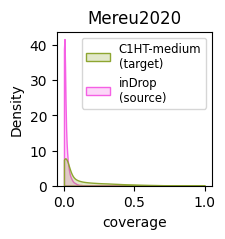

In [65]:
fig, ax = plt.subplots(figsize=(2, 2))

sns.kdeplot(
    bin_datasets[0], 
    cut=0, bw_method="silverman",
    color=sns.color_palette("husl", 15)[4],
    fill=True, label=list(dsname.values())[0] + "\n(target)",
    zorder=2
)
sns.kdeplot(
    bin_datasets[1],
    cut=0, bw_method="silverman",
    color=sns.color_palette("husl", 15)[13],
    fill=True, label=list(dsname.values())[1] + "\n(source)"
)

ax.set(title="Mereu2020")

ax.legend(fontsize="small")

fig.savefig(f"{conf.export}/kde.png", **kwarg_savefig)

In [53]:
np.random.seed(0)
unique = [v for v in bin_datasets[1].index if v in bin_datasets[0].index]
sampled_idx = np.random.choice(len(unique), 10000).tolist()

In [59]:
source = bin_datasets[1].loc[unique][sampled_idx]
target = bin_datasets[0].loc[unique][sampled_idx]

In [60]:
ot_emd = ot.da.EMDTransport(metric="sqeuclidean")
ot_emd.fit(
    Xs=source.values.reshape(-1, 1),
    Xt=target.values.reshape(-1, 1)
)

In [61]:
transformed = ot_emd.transform(Xs=source.values.reshape(-1, 1)).ravel()

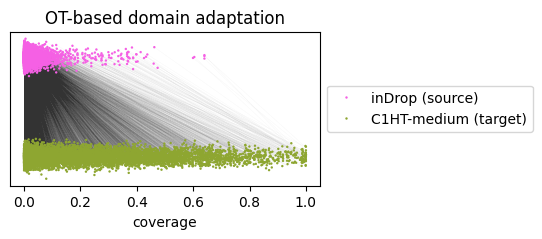

In [67]:
fig, ax = plt.subplots(figsize=(4, 2))

np.random.seed(0)

jitter = np.random.randn(source.size + target.size) / 20

sns.scatterplot(
    data=pd.DataFrame({
        "coverage": np.concatenate([source, target]),
        "cluster_id": [f"{list(dsname.values())[1]} (source)"] * source.size + [f"{list(dsname.values())[0]} (target)"] * target.size,
        "level": np.array([1] * source.size + [0] * target.size) + jitter,
    }),
    x="coverage", y="level", hue="cluster_id", s=3,
    palette = [
        sns.color_palette("husl", 15)[13],
        sns.color_palette("husl", 15)[4]
    ], linewidth=0

)

for xs, xtr, js, jtr in zip(source, transformed, jitter[:source.size], jitter[source.size:]):
    ax.plot(*np.array([
        [xs, xtr], 
        [1 + js, 0 + jtr]
    ]), c=".2", linewidth=.01, alpha=1, zorder=-1)

ax.legend(loc="center left", bbox_to_anchor=(1, .5))

ax.set(ylabel="")
ax.set_title("OT-based domain adaptation")
ax.tick_params(
    axis='both', which='both', 
    left=False, labelleft=False
)
fig.savefig(f"{conf.export}/ot.png", **kwarg_savefig)

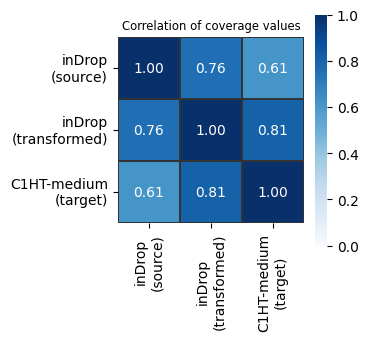

In [82]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.heatmap(
    data=pd.DataFrame({
        f"{list(dsname.values())[1]}\n(source)": source,
        f"{list(dsname.values())[1]}\n(transformed)": transformed,
        f"{list(dsname.values())[0]}\n(target)": target
    }).corr(),
    square=True, vmin=0, vmax=1,
    annot=True, fmt=".2f",
    cmap="Blues", ax=ax,
    linewidth=.1, linecolor=".2"
)

ax.set_title(
    "Correlation of coverage values",
    fontsize="small"
)

fig.savefig(f"{conf.export}/corr.png", **kwarg_savefig)

In [81]:
pd.DataFrame({
    "source": source,
    "transformed": transformed,
    "target": target
}).corr()

,source,transformed,target
source,1.000000,0.755062,0.611224
transformed,0.755062,1.000000,0.806277
target,0.611224,0.806277,1.000000
